In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

In [2]:
from zipline.api import order, record, symbol, set_benchmark
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
import math as m
from talib import EMA

In [3]:
OverallCapital = 100000

In [4]:
def initialize(context):
    set_benchmark(symbol("BTC"))
    context.asset = symbol('BTC')
    # Constant fitted separately depends on windows used
    context.const = 1.0

def handle_data(context, data):
 
    #EMWA average slow moving average, adjusted by vol 
    current_positions = context.portfolio.positions[symbol('BTC')].amount
    cash = context.portfolio.cash
    value = context.portfolio.portfolio_value
    total_value = cash + value
    current_pnl = context.portfolio.pnl
    trailing_window = data.history(symbol("BTC"), 'open', 360, '1d')
    if trailing_window.isnull().values.any():
        return
    short_ema = EMA(trailing_window.values, timeperiod=32)
    long_ema = EMA(trailing_window.values, timeperiod=180)
    emavevt = short_ema - long_ema
    emdf = pd.DataFrame(emavevt)
    emdf.fillna(0)
    average_ema = emdf.mean()
    std_ema = emdf.std()
    emafac = (short_ema[-1] - long_ema[-1] - average_ema) / std_ema
    Pct_to_invest = max(min(float(emafac) / context.const, 1), 0)
    Invest_target = Pct_to_invest * total_value
    Holding_target =total_value/value
    order_amount = Holding_target - current_positions
    order(context.asset, order_amount)
    if ( order_amount < 0):
        buy = False 
        sell = True
    elif ( order_amount > 0):
        buy = True
        sell = False
    else:
        buy = False
        sell = False
    new_position = context.portfolio.portfolio_value
    #
    record(BTC=data.current(symbol('BTC'), 'price'),
           short_ema=short_ema[-1],
           long_ema=long_ema[-1],
           average=average_ema,
           stddev=std_ema,
           emafac=emafac,
           target = Pct_to_invest,
           order= order_amount,
           position = new_position,
           total_value = total_value,
           buy=buy,
           sell=sell)  


In [5]:
def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return

In [6]:
#GDAX bitcoin exchange data
import cbpro
import dateutil.parser as dp

def getDateTimeFromISO8601String(s):
    d = dateutil.parser.parse(s)
    return d

In [9]:
from datetime import datetime
from datetime import timedelta
ts = int("1437350400")

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
start_date = datetime.utcfromtimestamp(ts)
end_date = start_date + pd.DateOffset(days=300)


In [10]:
a_tot=[]
a=[]
client = cbpro.PublicClient()
a_tot = client.get_product_historic_rates('BTC-USD',granularity=86400, start=start_date ,end=end_date)
b = pd.DataFrame(a_tot)
b.columns = [ 'time', 'low', 'high', 'open', 'close', 'volume' ]


for i in range(1,10):
   start_date = end_date +  pd.DateOffset(days=1)
   end_date = start_date + pd.DateOffset(days=300)
   if (start_date > datetime.today()):
     break
   a = client.get_product_historic_rates('BTC-USD',granularity=86400, start=start_date ,end=end_date)
   b2 = pd.DataFrame(a)
   b2.columns = [ 'time', 'low', 'high', 'open', 'close', 'volume' ]
   frames = [b2, b]
   result = pd.concat(frames)
   b =result


In [11]:
result['time'] = result['time'].apply(datetime.utcfromtimestamp)

In [12]:
result.rename(columns={'time':'date'},inplace=True)


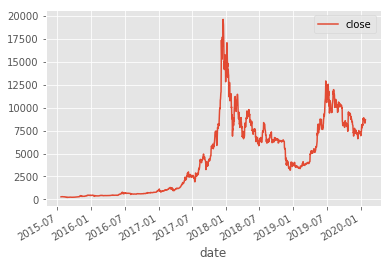

In [13]:
#Plot out the entire history

from matplotlib import style
resultstoplot = [result['date'],result['close']]
style.use("ggplot")
result.plot(x='date', y='close')
plt.show()

In [14]:
#Backfill data

In [15]:
result.sort_values(by=['date'], inplace=True,ascending=True)

In [16]:
data = OrderedDict()
tickers = ["BTC"]
result.set_index('date', inplace=True) 

In [17]:
result2 = result.resample('1D').bfill()

In [18]:

for ticker in tickers:
    data[ticker] = result2
    print(data[ticker].head())


panel = pd.Panel(data)
panel_minor_axis = ["low","high","open","close","volume"]
panel_major_axis = panel.major_axis.tz_localize(pytz.utc)

print(panel)

               low    high    open   close       volume
date                                                   
2015-07-21  276.85  281.27  279.96  277.32  4943.559434
2015-07-22  275.01  278.54  277.33  277.89  4687.909383
2015-07-23  276.28  279.75  277.96  277.39  5306.919575
2015-07-24  276.43  291.52  277.23  289.12  7362.469083
2015-07-25  286.82  291.67  289.12  289.70  4102.452960
<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 1652 (major_axis) x 5 (minor_axis)
Items axis: BTC to BTC
Major_axis axis: 2015-07-21 00:00:00 to 2020-01-27 00:00:00
Minor_axis axis: low to volume


In [19]:
import trading_calendars
from trading_calendars.always_open import AlwaysOpenCalendar

In [22]:
#approx 1y window
#This is a bad one, use one that has some downturns

perf = zipline.run_algorithm(start=datetime(2016, 8, 1, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2017, 8, 1, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      trading_calendar=AlwaysOpenCalendar(),
                      capital_base=OverallCapital,
                      handle_data=handle_data,
                      data=panel)

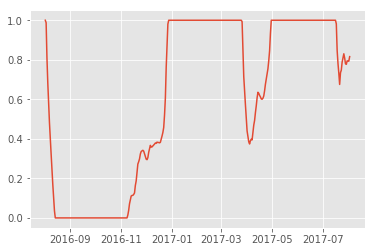

In [23]:
#plot the cumulative returns
from matplotlib import style
style.use("ggplot")
plt.plot(perf.target)

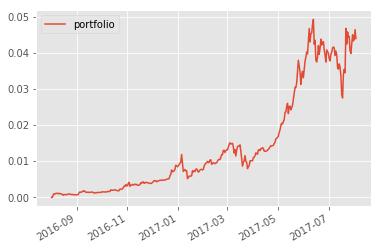

In [24]:
perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
plt.legend(loc=2)
plt.show()

Start date,2016-08-01
End date,2017-08-01
Total months,17
,Backtest
Annual return,3.0%
Cumulative returns,4.4%
Annual volatility,2.1%
Sharpe ratio,1.41
Calmar ratio,1.45
Stability,0.80
Max drawdown,-2.1%


/home/christopher/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.07,2017-06-11,2017-07-16,NaT,NaN
1,0.71,2017-03-03,2017-03-24,2017-04-26,39
2,0.66,2017-01-04,2017-01-11,2017-02-23,37
3,0.64,2017-05-24,2017-05-27,2017-06-02,8
4,0.35,2017-06-06,2017-06-07,2017-06-10,4


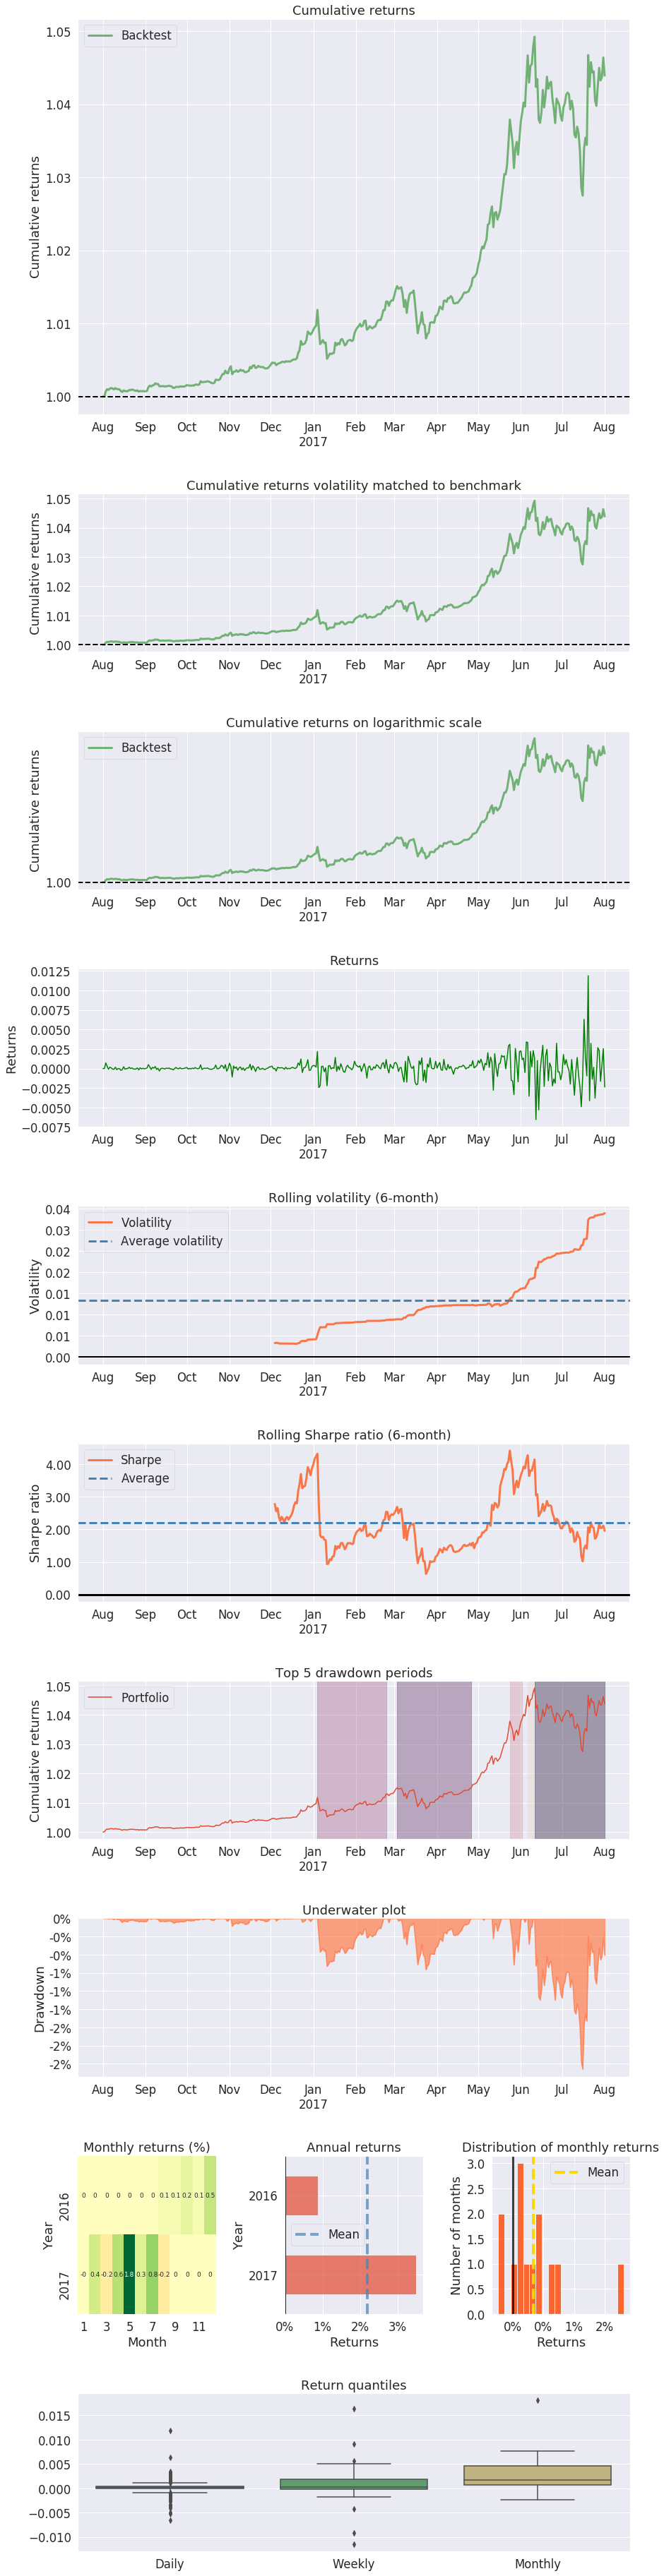

In [25]:
#Analyse the results using pyfolio - very handy
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)